# Reference
Youtube Video: https://www.youtube.com/watch?v=doDUihpj6ro&ab_channel=NicholasRenotte

# Import & Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe scikit-learn matplotlib

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

# Keypoint using MP Holistic

In [3]:
# mediapipe holisitic is a trained model
mp_holistic = mp.solutions.holistic     # Holistic model
mp_drawing = mp.solutions.drawing_utils # Mediapipe Drawing Utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color Conversion (cv imports webcam video as BGR but MP uses RGB)
    image.flags.writeable = False                  # Image is no longer writeable (this saves memory)
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color conversion (RGB 2 BGR)
    return image, results

In [5]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image,results.face_landmarks, mp_holistic.) # draw face connections 
    mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # draw pose connections
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # draw left hand connections
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # draw right hand connections

In [106]:
def draw_styled_landmarks(image, results):
    #mp_drawing.draw_landmarks(image,results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)  
    # draw pose connections
    #mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                         mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2),
    #                         mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    # draw left hand connections
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=2, circle_radius=2)) 
    # draw right hand connections
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=2, circle_radius=2)) 

### Capture Webcam Stream

In [7]:
# setup code to capture webcam
cap = cv2.VideoCapture(0)

#loop through all images in camera feed

# access Mediapipe trained model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():   
        
        # read feed
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # draw landmarks
        draw_styled_landmarks(image,results)

        #show to screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


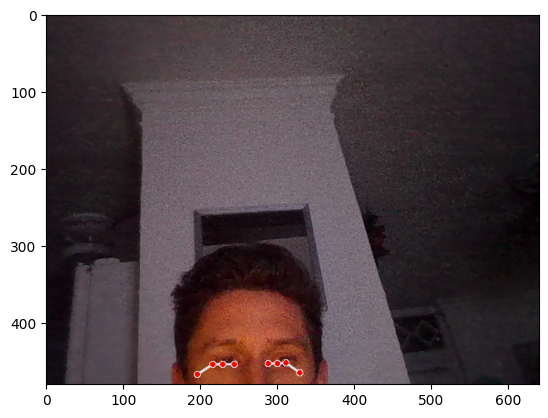

In [8]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [9]:
def extract_keypoints(results):
    # face landmark array
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

# Setup Folders for Collection

In [10]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['hello','thanks','iloveyou'])

# Number of videos worth of data for each action
no_sequence = 30

# Number of frames in the videos 
sequence_length = 30 

In [11]:
# Create one folder for each action
# The following is the folder structure
'''
/MP_Data
    /hello
        /0
        /1
        /...
        /29
    /thanks
        /0
        /1
        /...
        /29
    /iloveyou
        /0
        /1
        /...
        /29
'''

for action in actions:
    for sequence in range(no_sequence):
        try:
            os.makedirs(os.path.join(DATA_PATH, action ,str(sequence)))
        except:
            pass

# Collect Keypoint Values for Training and Testing

In [26]:
# setup code to capture webcam
cap = cv2.VideoCapture(0)

#loop through all images in camera feed

# access Mediapipe trained model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    #loop through actions
    for action in actions:
        
        # loop through sequences aka videos
        for sequence in range(no_sequence):
            
            # loop through video length aka sequence length
            for frame_num in range(sequence_length):
                
                # read feed
                ret, frame = cap.read()

                # make detections
                image, results = mediapipe_detection(frame, holistic)

                # draw landmarks
                draw_styled_landmarks(image,results)
                
                # Apply wait logic for data collection
                if frame_num == 0:
                    cv2.putText(image, f'STARTING COLLECT: {action} SEQ {sequence}', (120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action,sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(3000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action,sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                # Keypoint extraction and save
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path,keypoints)

                # break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    
    cap.release()
    cv2.destroyAllWindows()

In [51]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [52]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [53]:
label_map = {label:num for num, label in enumerate(actions)}

In [54]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [55]:
sequences, labels = [],[] # create two blank arrays sequences is our X data and labels is Y data

for action in actions:
    for sequence in range(no_sequence):
        window = [] # represent all frames from preticular sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [56]:
X = np.array(sequences)

In [57]:
y = to_categorical(labels).astype(int)

In [85]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

# Build and Train LSTM Neural Network

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard # trace and model modeel as its training 

In [60]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

2022-12-26 22:34:04.372204: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-12-26 22:34:04.372222: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-12-26 22:34:04.457941: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-12-26 22:34:04.458110: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [61]:
model = Sequential()
model.add(LSTM(64,return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128,return_sequences=True, activation='relu'))
model.add(LSTM(64,return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0],activation='softmax'))

In [62]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=1100, callbacks=[tb_callback])

Epoch 1/1100
2/3 [===================>..........] - ETA: 0s - loss: 1.7764 - categorical_accuracy: 0.4609

2022-12-26 22:34:09.785452: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-12-26 22:34:09.785473: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


3/3 [==============================] - 2s 405ms/step - loss: 3.9180 - categorical_accuracy: 0.4128
Epoch 2/1100
2/3 [===================>..........] - ETA: 0s - loss: 11.3229 - categorical_accuracy: 0.4062

2022-12-26 22:34:10.102374: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-12-26 22:34:10.102956: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2022-12-26 22:34:10.143428: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 6065 callback api events and 6079 activity events. 
2022-12-26 22:34:10.225529: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-12-26 22:34:10.312369: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_12_26_22_34_10
2022-12-26 22:34:10.392087: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_12_26_22_34_10/nrgm15.trace.json.gz
2022-12-26 22:34:10.467956: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/p

3/3 [==============================] - 0s 57ms/step - loss: 11.5294 - categorical_accuracy: 0.4090
Epoch 3/1100
3/3 [==============================] - 0s 58ms/step - loss: 16.3546 - categorical_accuracy: 0.3817
Epoch 4/1100
3/3 [==============================] - 0s 57ms/step - loss: 6.4448 - categorical_accuracy: 0.3933
Epoch 5/1100
3/3 [==============================] - 0s 66ms/step - loss: 4.8930 - categorical_accuracy: 0.4187
Epoch 6/1100
3/3 [==============================] - 0s 57ms/step - loss: 23.9219 - categorical_accuracy: 0.3091
Epoch 7/1100
3/3 [==============================] - 0s 61ms/step - loss: 19.6144 - categorical_accuracy: 0.3112
Epoch 8/1100
3/3 [==============================] - 0s 59ms/step - loss: 19.8119 - categorical_accuracy: 0.2994
Epoch 9/1100
3/3 [==============================] - 0s 57ms/step - loss: 22.5444 - categorical_accuracy: 0.3581
Epoch 10/1100
3/3 [==============================] - 0s 59ms/step - loss: 27.9189 - categorical_accuracy: 0.3347
Epoch 

3/3 [==============================] - 0s 58ms/step - loss: 0.6667 - categorical_accuracy: 0.6714
Epoch 76/1100
3/3 [==============================] - 0s 60ms/step - loss: 0.4653 - categorical_accuracy: 0.8003
Epoch 77/1100
3/3 [==============================] - 0s 57ms/step - loss: 0.5319 - categorical_accuracy: 0.7633
Epoch 78/1100
3/3 [==============================] - 0s 60ms/step - loss: 0.5885 - categorical_accuracy: 0.7319
Epoch 79/1100
3/3 [==============================] - 0s 57ms/step - loss: 0.5067 - categorical_accuracy: 0.7416
Epoch 80/1100
3/3 [==============================] - 0s 58ms/step - loss: 0.5749 - categorical_accuracy: 0.7437
Epoch 81/1100
3/3 [==============================] - 0s 58ms/step - loss: 0.4520 - categorical_accuracy: 0.8688
Epoch 82/1100
3/3 [==============================] - 0s 59ms/step - loss: 0.4547 - categorical_accuracy: 0.8493
Epoch 83/1100
3/3 [==============================] - 0s 56ms/step - loss: 0.6696 - categorical_accuracy: 0.6615
Epoch 

KeyboardInterrupt: 

In [64]:
res = model.predict(X_test)

In [91]:
actions[np.argmax(res[3])]

'iloveyou'

In [90]:
actions[np.argmax(y_test[3])]

'iloveyou'

# Save Model

In [92]:
model.save('action.h5')

In [93]:
# model.load_weights('action.h5')

# Evaluate using Confusion Matrix and Accuracy

In [94]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [95]:
yhat = model.predict(X_test)

In [96]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [97]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]])

In [98]:
accuracy_score(ytrue,yhat)

1.0

# Test in Real Time

In [110]:
colors = [(245,117,16),(117,245,16),(16,117,245)]
def prob_viz(res,actions,input_frame,colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,600+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame
    

In [113]:
#plt.imshow(prob_viz(res,actions,image,colors))

In [115]:
# Init
sequence = [] # append to this sequence to make predictions from
sentence = [] 
threshold = 0.7 # confidence metric

# setup code to capture webcam
cap = cv2.VideoCapture(0)

#loop through all images in camera feed

# access Mediapipe trained model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():   
        
        # read feed
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # draw landmarks
        draw_styled_landmarks(image,results)
        
        # prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            
        # visualization logic
        if res[np.argmax(res)] > threshold:
            if len(sentence) > 0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
        if len(sentence) > 5:
            sentence = sentence[-5:]
            
        # visualize probabilities
        #image = prob_viz(res,actions,image,colors)
            
        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2,cv2.LINE_AA)

        #show to screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [ ]:
cap.release()
cv2.destroyAllWindows()